<a href="https://colab.research.google.com/github/RIT20/Snake-classification/blob/main/Snake_in_the_Hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The objective is to detect the species of snakes into 35 different categories from its image.**

Collected Dataset from different web resources, then performed image data transformation using helper functions provided by FastAI. Increased data size using Image Data Augmentation.


**Used pre-trained model of resnet50 to train on my dataset, and obtained the optimum learning rate.**

*Used weighted F1-score as my model evaluation metric. Obtained F1-score of 47.106 on validation set and of 51.236 on test.*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import cv2
import glob
from sklearn.preprocessing import LabelEncoder
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
from pathlib import Path

In [ ]:
data_path = "/content/drive/MyDrive/Snake in the Hood/8a95c26e1bab11eb.zip (Unzipped Files)/dataset/train"
train_path = os.path.join(data_path , "*jpg")

In [ ]:
#files = glob.glob(path)
#data=[]
#for file in files:
#    image = cv2.imread(file)
#    data.append(image)

In [ ]:
data_folder = Path('/content/drive/MyDrive/Snake in the Hood/8a95c26e1bab11eb.zip (Unzipped Files)/dataset')

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Snake in the Hood/8a95c26e1bab11eb.zip (Unzipped Files)/dataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Snake in the Hood/8a95c26e1bab11eb.zip (Unzipped Files)/dataset/test.csv')

In [ ]:

# fit and fit_transform
encoder = LabelEncoder()
encoder.fit(train_df['breed'])
train_df['breed'] = encoder.transform(train_df['breed'])
train_df['breed']

0       15
1       25
2       34
3       23
4        0
        ..
5503    12
5504    20
5505    34
5506    26
5507    12
Name: breed, Length: 5508, dtype: int64

In [ ]:
list(encoder.inverse_transform([4, 5, 16, 25, 34]))

['crotalus-horridus',
 'crotalus-ruber',
 'nerodia-fasciata',
 'pantherophis-vulpinus',
 'thamnophis-sirtalis']

In [ ]:
# use fastai helper function to function same below operation
test_img = ImageList.from_df( test_df, path = data_folder ,  folder = 'test', suffix = '.jpg')
test_img


ImageList (2361 items)
Image (3, 171, 128),Image (3, 96, 128),Image (3, 112, 128),Image (3, 171, 128),Image (3, 233, 128)
Path: /content/drive/MyDrive/Snake in the Hood/8a95c26e1bab11eb.zip (Unzipped Files)/dataset

In [ ]:
# max_rotate=10.0, max_zoom=1.3, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75
tfms = get_transforms(do_flip=True, flip_vert= True, max_rotate=20.0, max_zoom=1.2, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

In [ ]:
src = (ImageList.from_df(train_df, path=data_folder, folder='train', suffix = '.jpg')
       .split_by_rand_pct(0.2)
       #.split_none()
       .label_from_df()
       .add_test(test_img))

In [ ]:
data = (src.transform(tfms, size = 400 , padding_mode='reflection')
        .databunch(path='.', bs=64, device= torch.device('cuda:0')).normalize(imagenet_stats))

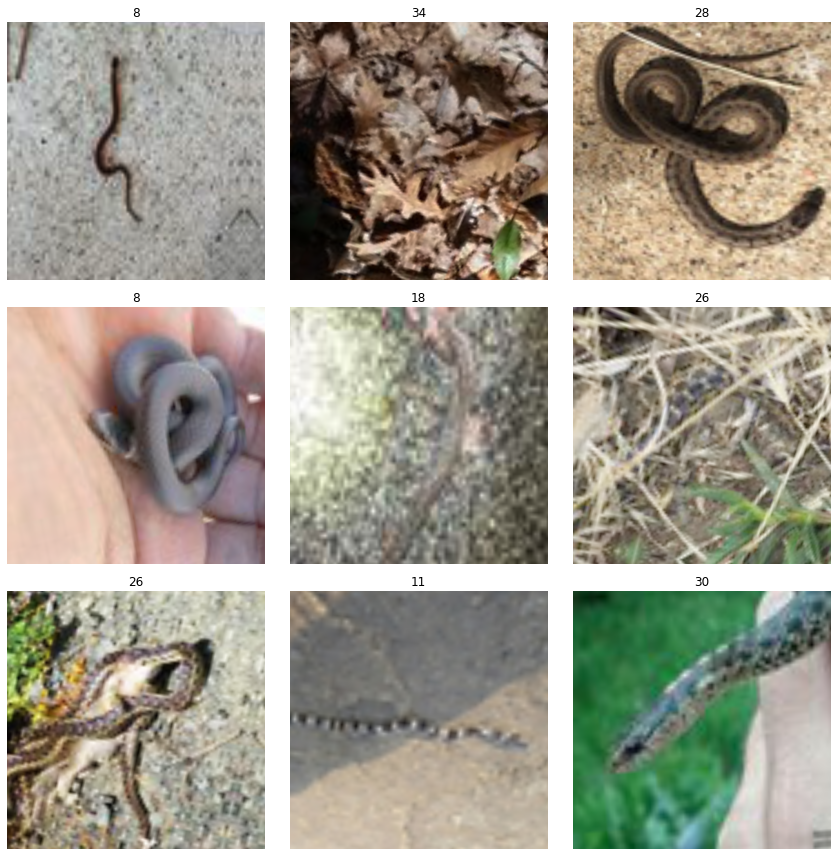

In [ ]:
data.show_batch(rows=3, figsize=(12,12))


In [ ]:
print(data.classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [ ]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[FBeta(beta=1, average='macro'), accuracy],
                   callback_fns=ShowGraph)
#learn = cnn_learner(data=data, base_arch=models.resnet101, metrics=[FBeta(beta=1, average='macro'), accuracy],
#                    callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.summary()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 3e-03
#learn.fit_one_cycle(15, slice(lr))

learn.fit_one_cycle(15, max_lr=slice(lr))

In [ ]:

learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
data.show_batch(rows=3, figsize=(12,12))


In [ ]:
#learn.fit_one_cycle(10, slice(1e-06, lr/8),wd=0.15)

learn.fit_one_cycle(10,slice(1e-05, lr/8),wd=0.15)

In [ ]:
learn.freeze_to(-3)


In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
#learn.fit_one_cycle(6, slice(1e-06, lr/10),wd=0.1)
learn.fit_one_cycle(6, slice(1e-06, lr/10 ),wd=0.1)


In [ ]:
learn.freeze_to(-2)


In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
 learn.fit_one_cycle(6, max_lr=1e-04,wd=0.1)


In [ ]:
learn.freeze_to(-1)


In [ ]:
lr = 3e-03
learn.fit_one_cycle(5, slice(lr/8),wd=0.05)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(7,6))

In [ ]:
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
from sklearn.metrics import f1_score, accuracy_score
valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
valid_preds = np.array(valid_preds)
y = np.array(y+1)
accuracy_score(valid_preds,y),f1_score(valid_preds,y, average='weighted')

In [ ]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
#preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i])+1 for i in range(len(preds))]

labelled_preds = np.array(labelled_preds)

In [ ]:
labelled_preds

In [ ]:
labelled_preds = encoder.inverse_transform(labelled_preds - 1 )
labelled_preds

In [ ]:
df = pd.DataFrame({'image_id':test_df['image_id'], 'breed':labelled_preds}, columns=['image_id', 'breed'])
df.to_csv('Final.csv', index=False)